In [10]:
import sdepy
import numpy as np

@sdepy.integrate
def my_process(t, x, theta=1., k=1., sigma=1.):
    return {'dt': k*(theta - x), 'dw': sigma}

x = my_process(x0=1, paths=100*1000, steps=100)


In [14]:
timeline = np.linspace(0., 1., 5)
x(timeline)
timeline

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [42]:
ALPHAVANTAGE_API = 'S09O7OIWCQWSMDGQ'
import requests
import json
import pandas as pd

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&month=2009-01&interval=1min&apikey={ALPHAVANTAGE_API}'
r = requests.get(url)
data = r.json()["Time Series (1min)"]
print(data)
df = pd.DataFrame([data[elem] for elem in data])
df.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
}, inplace=True)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(int)

df['Date'] = data.keys()
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
#with open('data.json', 'w') as f:
#    json.dump(data, f)

{'2009-01-30 19:57:00': {'1. open': '51.0345', '2. high': '51.0345', '3. low': '51.0345', '4. close': '51.0345', '5. volume': '209'}, '2009-01-30 17:44:00': {'1. open': '51.0624', '2. high': '51.0624', '3. low': '51.0624', '4. close': '51.0624', '5. volume': '84726'}, '2009-01-30 17:15:00': {'1. open': '51.3662', '2. high': '51.3662', '3. low': '51.3662', '4. close': '51.3662', '5. volume': '2651'}, '2009-01-30 17:14:00': {'1. open': '51.0624', '2. high': '51.0624', '3. low': '51.0624', '4. close': '51.0624', '5. volume': '359'}, '2009-01-30 17:07:00': {'1. open': '50.8674', '2. high': '50.8730', '3. low': '50.8674', '4. close': '50.8730', '5. volume': '334'}, '2009-01-30 16:59:00': {'1. open': '51.3499', '2. high': '51.3499', '3. low': '51.3499', '4. close': '51.3499', '5. volume': '104'}, '2009-01-30 16:46:00': {'1. open': '50.9621', '2. high': '50.9621', '3. low': '50.9621', '4. close': '50.9621', '5. volume': '313'}, '2009-01-30 16:45:00': {'1. open': '50.9621', '2. high': '50.9621

In [43]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2009-01-30 19:57:00,51.0345,51.0345,51.0345,51.0345,209
2009-01-30 17:44:00,51.0624,51.0624,51.0624,51.0624,84726
2009-01-30 17:15:00,51.3662,51.3662,51.3662,51.3662,2651
2009-01-30 17:14:00,51.0624,51.0624,51.0624,51.0624,359
2009-01-30 17:07:00,50.8674,50.8730,50.8674,50.8730,334
...,...,...,...,...,...
2009-01-30 14:49:00,51.3800,51.4301,51.3744,51.4053,11008
2009-01-30 14:48:00,51.3511,51.3744,51.3465,51.3688,6929
2009-01-30 14:47:00,51.3633,51.3800,51.3465,51.3465,7970


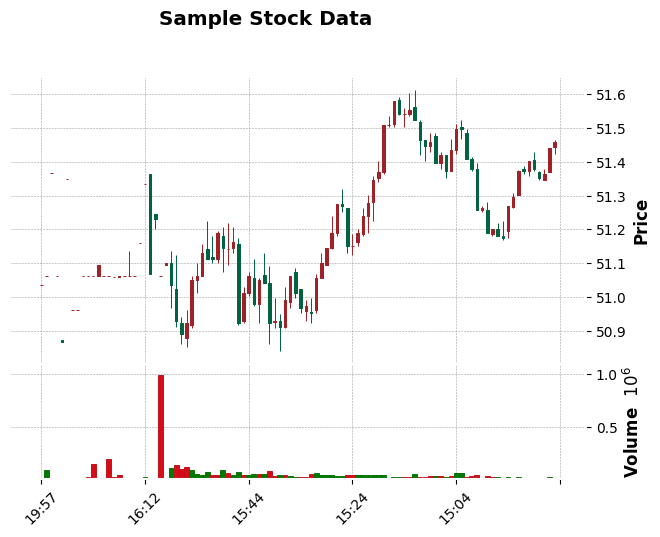

In [44]:
import mplfinance as mpf
mpf.plot(df, type='candle', style='charles', volume=True, title='Sample Stock Data', ylabel='Price')
